In [45]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [3]:
# Projektwurzel: ein Ordner über "notebooks"
project_root = Path("..").resolve()
project_root

PosixPath('/Users/kat/Documents/Stackfuel/Biomech_Project_2025')

In [4]:
# Ordner, in dem "data/matches/<match_id>/*" liegt
sc_data_root = project_root / "data" / "raw" / "opendata-master" / "data"

print(sc_data_root)

/Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data


In [5]:
# Pfad, in dem "PhasesOfPlayAggregator.py" liegt
pop_agg_path = (
    project_root
    / "data"
    / "raw"
    / "opendata-master"
    / "resources"
    / "Tutorials"
    / "[Advanced] Aggregating Phases of Play"
)

sys.path.append(str(pop_agg_path))

from PhasesOfPlayAggregator import PhasesOfPlayAggregator

print(pop_agg_path)
print("Import OK ")


/Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/resources/Tutorials/[Advanced] Aggregating Phases of Play
Import OK 


In [6]:
def aggregate_one_match(match_id: int, sc_data_root: Path) -> pd.DataFrame:
    """
    Lädt phases_of_play für ein Match und erzeugt ein Team-Match-DataFrame
    mit allen In- und Out-of-possession-Aggregaten.

    Output: eine Zeile pro (match_id, team_id, team_name)
    """

    # 1) CSV-Pfad bauen
    phases_path = sc_data_root / "matches" / str(match_id) / f"{match_id}_phases_of_play.csv"
    print(f"Lade Match {match_id} von {phases_path}")

    phases_df = pd.read_csv(phases_path)

    # 2) Aggregator instanziieren
    agg = PhasesOfPlayAggregator(phases_of_play_df=phases_df)

    # 3) Aggregates für In-possession holen
    in_pos = agg.get_in_possession_aggregates()
    in_pos = in_pos.rename(
        columns={
            "team_in_possession_id": "team_id",
            "team_in_possession_shortname": "team_name",
        }
    )

    # 4) Aggregates für Out-of-possession holen
    out_pos = agg.get_out_of_possession_aggregates()
    out_pos = out_pos.rename(
        columns={
            "team_out_of_possession_id": "team_id",
            "team_out_of_possession_shortname": "team_name",
        }
    )

    # 5) Zusammenführen -> eine Zeile pro Team im Match
    merged = in_pos.merge(
        out_pos,
        on=["match_id", "team_id", "team_name"],
        suffixes=("_ip", "_oop"),
    )

    return merged


In [8]:
match_ids = [
    1886347,
    1899585,
    1925299,
    1953632,
    1996435,
    2006229,
    2011166,
    2013725,
    2015213,
    2017461,
]

In [9]:
all_games_list = []

for mid in match_ids:
    try:
        df_match = aggregate_one_match(mid, sc_data_root)
        all_games_list.append(df_match)
    except FileNotFoundError:
        print(f"Datei für Match {mid} nicht gefunden – wird übersprungen.")

# Alles zu einem großen DataFrame zusammenfügen
all_games_df = pd.concat(all_games_list, ignore_index=True)

all_games_df.head()


Lade Match 1886347 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches/1886347/1886347_phases_of_play.csv
Lade Match 1899585 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches/1899585/1899585_phases_of_play.csv
Lade Match 1925299 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches/1925299/1925299_phases_of_play.csv
Lade Match 1953632 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches/1953632/1953632_phases_of_play.csv
Lade Match 1996435 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches/1996435/1996435_phases_of_play.csv
Lade Match 2006229 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches/2006229/2006229_phases_of_play.csv
Lade Match 2011166 von /Users/kat/Documents/Stackfuel/Biomech_Project_2025/data/raw/opendata-master/data/matches

,match_id,team_id,team_name,count_build_up,total_time_build_up,count_player_possessions_build_up,count_possession_lost_in_phase_build_up,count_possession_lead_to_shot_build_up,count_possession_lead_to_goal_build_up,avg_start_width_build_up,...,count_into_transition_from_defending_set_play,count_into_quick_break_from_defending_set_play,count_into_direct_from_defending_set_play,count_into_chaotic_from_defending_set_play,count_into_low_block_from_defending_set_play,count_into_medium_block_from_defending_set_play,count_into_high_block_from_defending_set_play,count_into_defending_quick_break_from_defending_set_play,count_into_defending_transition_from_defending_set_play,count_into_defending_direct_from_defending_set_play
0,1886347,1805,Newcastle,39.0,353.7,129.0,4.0,3.0,0.0,41.585556,...,NaN,NaN,NaN,2.0,2.0,3.0,NaN,NaN,NaN,NaN
1,1886347,4177,Auckland FC,24.0,219.0,72.0,3.0,3.0,0.0,45.182083,...,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,NaN
2,1899585,867,Wellington P FC,33.0,280.5,102.0,6.0,1.0,0.0,45.071613,...,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN
3,1899585,4177,Auckland FC,16.0,149.1,45.0,2.0,0.0,0.0,45.026923,...,1.0,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN
4,1925299,871,Perth Glory,40.0,324.1,88.0,3.0,1.0,1.0,38.425000,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
print(all_games_df.shape)
all_games_df[["match_id", "team_name"]].drop_duplicates()

(20, 371)


,match_id,team_name
0,1886347,Newcastle
1,1886347,Auckland FC
2,1899585,Wellington P FC
3,1899585,Auckland FC
4,1925299,Perth Glory
5,1925299,Brisbane FC
6,1953632,CC Mariners
7,1953632,Melbourne City
8,1996435,Adelaide United
9,1996435,Sydney FC


In [11]:
print(all_games_df.shape)


(20, 371)


In [16]:
team_phase_summary = (
    all_games_df
    .groupby("team_name")
    .agg({
        "total_time_build_up": "mean",
        "total_time_create": "mean",
        "total_time_finish": "mean",
        "total_time_low_block": "mean",
        "total_time_medium_block": "mean",
        "total_time_high_block": "mean"
    })
)

team_phase_summary

,total_time_build_up,total_time_create,total_time_finish,total_time_low_block,total_time_medium_block,total_time_high_block
team_name,,,,,,
Adelaide United,345.10,556.900,289.50,533.100,630.100,347.100
Auckland FC,192.55,552.175,341.70,258.125,559.475,292.525
Brisbane FC,270.90,832.200,720.50,253.400,482.000,324.100
CC Mariners,331.10,441.800,98.80,334.200,1314.200,240.400
Macarthur FC,315.30,552.700,153.70,447.000,830.500,301.500
Melbourne City,270.95,1072.350,390.60,126.250,497.250,323.200
Melbourne V FC,157.30,578.250,450.65,160.700,347.450,147.900
Newcastle,353.70,646.900,150.10,478.400,685.700,219.000
Perth Glory,324.10,482.000,253.40,720.500,832.200,270.900


In [20]:
PHASE_TIME_COLS = [
    "total_time_build_up",
    "total_time_create",
    "total_time_finish",
    "total_time_transition",
    "total_time_low_block",
    "total_time_medium_block",
    "total_time_high_block"
]
all_games_df["total_time_all_phases"] = (
    all_games_df[PHASE_TIME_COLS].sum(axis=1)
)
for col in PHASE_TIME_COLS:
    pct_col = col + "_pct"
    all_games_df[pct_col] = (
        all_games_df[col] / all_games_df["total_time_all_phases"] * 100
    )


In [21]:
PHASE_PCT_COLS = [c + "_pct" for c in PHASE_TIME_COLS]

team_identity_df = (
    all_games_df
    .groupby("team_name")[PHASE_PCT_COLS]
    .mean()
    .reset_index()
)

team_identity_df


,team_name,total_time_build_up_pct,total_time_create_pct,total_time_finish_pct,total_time_transition_pct,total_time_low_block_pct,total_time_medium_block_pct,total_time_high_block_pct
0,Adelaide United,12.609617,20.348582,10.578047,1.278866,19.478954,23.023239,12.682695
1,Auckland FC,8.305716,24.106757,14.730581,3.148822,12.066953,24.909112,12.732058
2,Brisbane FC,9.396136,28.864764,24.990462,NaN,8.789151,16.718116,11.241372
3,CC Mariners,11.904933,15.885229,3.552423,0.744283,12.016396,47.252984,8.643751
4,Macarthur FC,11.944539,20.937985,5.822631,1.477441,16.933742,31.461909,11.421752
5,Melbourne City,10.068484,39.400503,14.529932,0.860970,4.707760,18.477016,11.955336
6,Melbourne V FC,8.203797,30.156882,23.504747,3.932314,8.379267,18.121336,7.701658
7,Newcastle,13.959271,25.530823,5.923909,NaN,18.880732,27.062120,8.643145
8,Perth Glory,11.084890,16.485396,8.666803,1.392024,24.642588,28.462959,9.265340
9,Sydney FC,10.502227,24.256349,16.645946,2.115546,8.586989,23.216925,14.676018


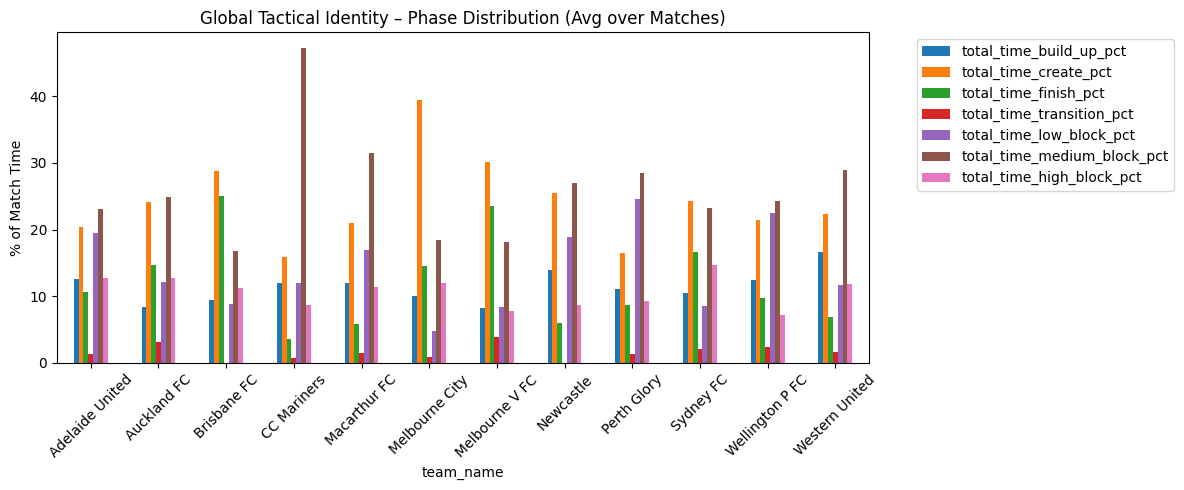

In [24]:

team_identity_df.set_index("team_name")[PHASE_PCT_COLS].plot(
    kind="bar",
    figsize=(12, 5)
)

plt.ylabel("% of Match Time")
plt.title("Global Tactical Identity – Phase Distribution (Avg over Matches)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [26]:
RADAR_COLS = [
    "total_time_build_up_pct",
    "total_time_create_pct",
    "total_time_finish_pct",
    "total_time_low_block_pct",
    "total_time_medium_block_pct",
    "total_time_high_block_pct"
]

RADAR_LABELS = [
    "Build-up",
    "Create",
    "Finish",
    "Low Block",
    "Mid Block",
    "High Block"
]
def plot_team_radar(row, cols, labels):
    values = row[cols].values
    values = np.append(values, values[0])

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
    angles = np.append(angles, angles[0])

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    ax.set_thetagrids(angles[:-1] * 180 / np.pi, labels)
    ax.set_title(row["team_name"], y=1.1)
    ax.set_ylim(0, max(values) * 1.2)

    plt.show()


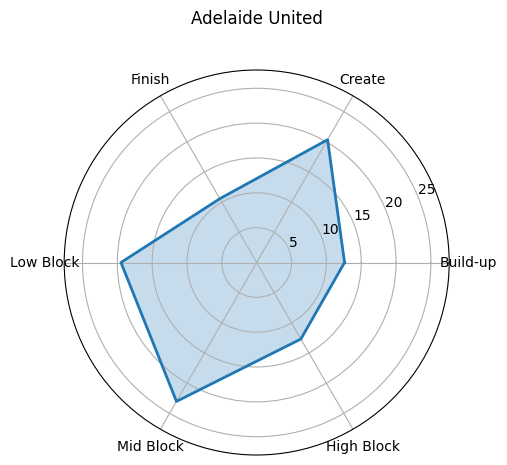

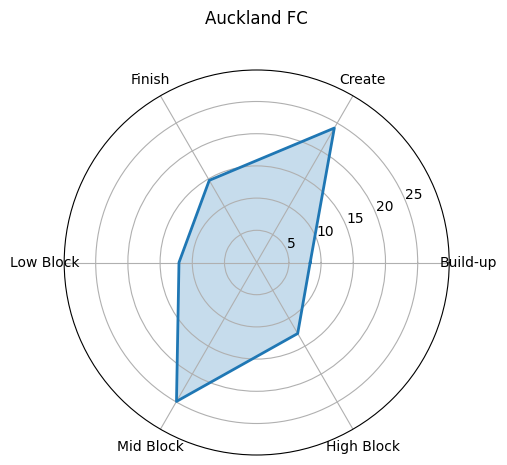

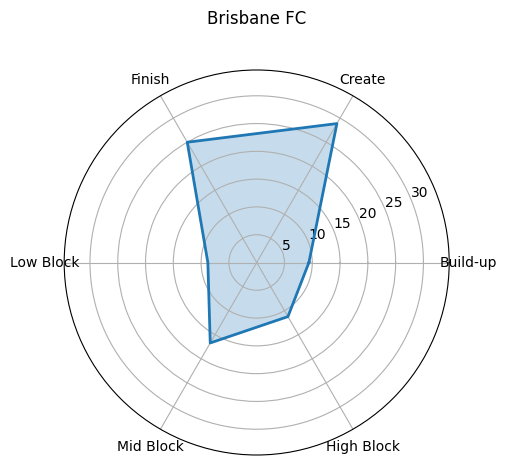

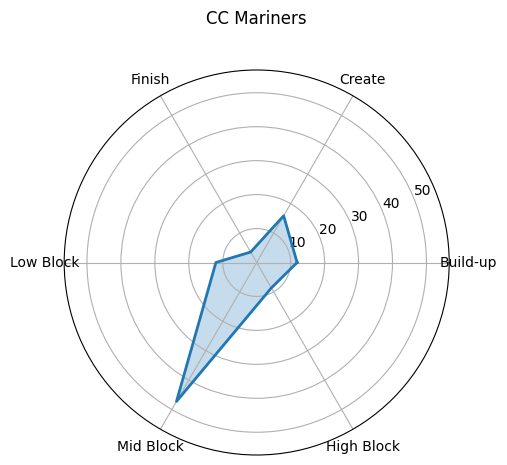

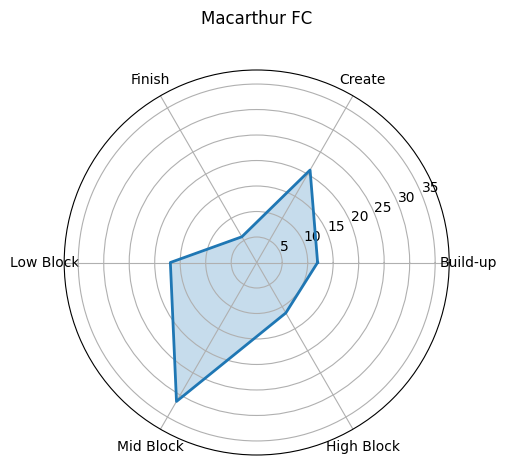

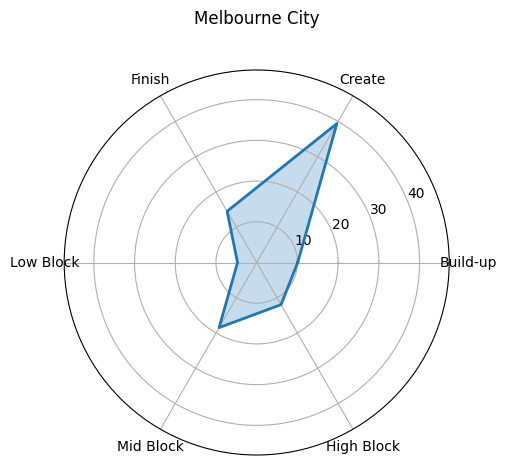

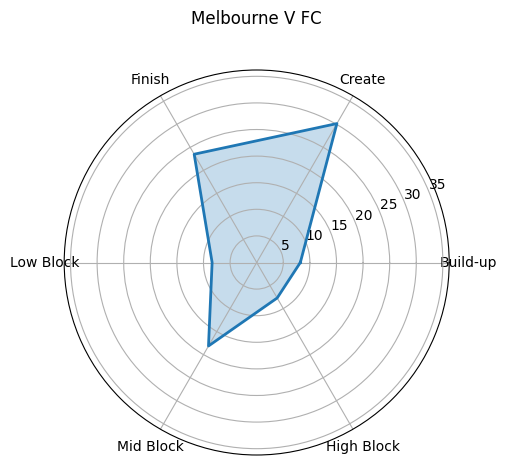

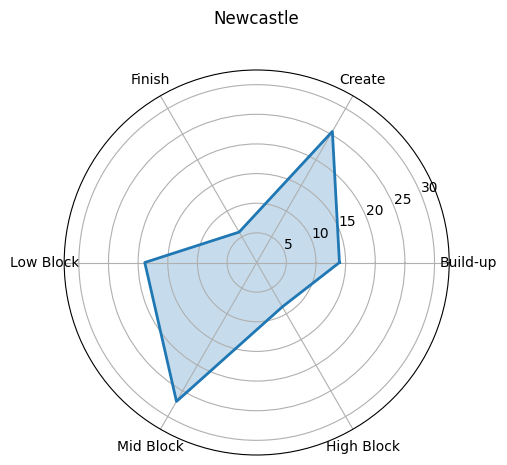

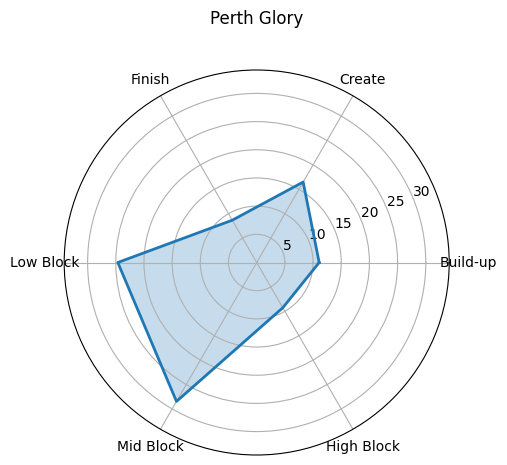

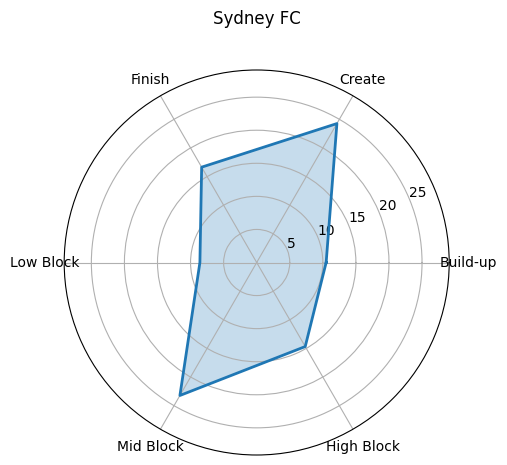

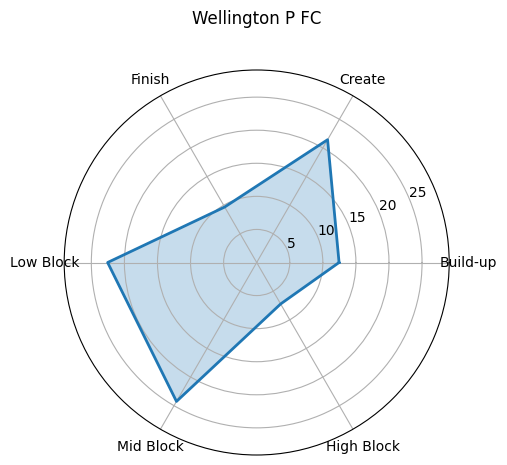

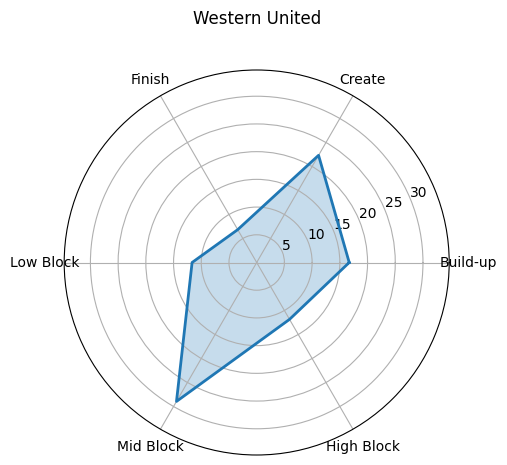

In [32]:
for _, row in team_identity_df.iterrows():
    plot_team_radar(row, RADAR_COLS, RADAR_LABELS)


In [28]:
for phase in ["build_up", "create", "finish", "transition"]:
    all_games_df[f"avg_duration_{phase}"] = (
        all_games_df[f"total_time_{phase}"] /
        all_games_df[f"count_{phase}"]
    )


In [29]:
tempo_cols = [c for c in all_games_df.columns if c.startswith("avg_duration_")]

team_tempo_df = (
    all_games_df
    .groupby("team_name")[tempo_cols]
    .mean()
    .reset_index()
)

team_tempo_df


,team_name,avg_duration_build_up,avg_duration_create,avg_duration_finish,avg_duration_transition
0,Adelaide United,8.216667,7.525676,7.423077,11.666667
1,Auckland FC,8.708795,7.968261,7.442288,11.920909
2,Brisbane FC,8.738710,9.145055,12.008333,NaN
3,CC Mariners,8.948649,7.889286,7.600000,10.350000
4,Macarthur FC,8.521622,7.676389,7.685000,13.000000
5,Melbourne City,8.210606,11.208100,7.930314,8.975000
6,Melbourne V FC,7.181573,8.633772,10.651037,13.770000
7,Newcastle,9.069231,8.401299,5.360714,NaN
8,Perth Glory,8.102500,6.885714,7.678788,10.175000
9,Sydney FC,8.158750,7.998542,9.515625,10.350000


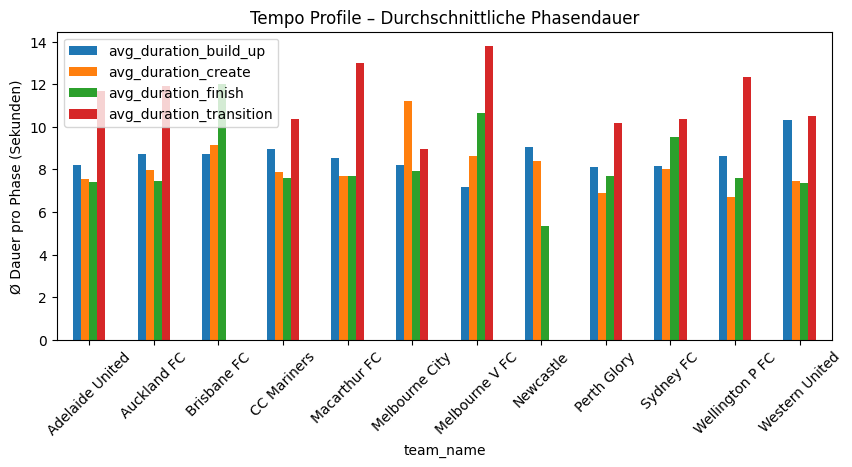

In [30]:
team_tempo_df.set_index("team_name").plot(
    kind="bar",
    figsize=(10, 4)
)

plt.ylabel("Ø Dauer pro Phase (Sekunden)")
plt.title("Tempo Profile – Durchschnittliche Phasendauer")
plt.xticks(rotation=45)
plt.show()


In [36]:
# A3.0 – Stability vorbereiten

# Alle "same-phase"-Transitions identifizieren
same_phase_cols = [
    c for c in all_games_df.columns
    if c.startswith("count_into_") and "_from_" in c
    and c.split("_from_")[0].replace("count_into_", "") 
        == c.split("_from_")[1]
]

# Alle Transition-Spalten
transition_cols = [
    c for c in all_games_df.columns
    if c.startswith("count_into_") and "_from_" in c
]

# Summen berechnen
all_games_df["same_phase_transitions"] = all_games_df[same_phase_cols].sum(axis=1)
all_games_df["total_transitions_all"] = all_games_df[transition_cols].sum(axis=1)

# Stability Index
all_games_df["stability_index"] = (
    all_games_df["same_phase_transitions"] /
    all_games_df["total_transitions_all"]
)

all_games_df[[
    "match_id",
    "team_name",
    "same_phase_transitions",
    "total_transitions_all",
    "stability_index"
]].head()

,match_id,team_name,same_phase_transitions,total_transitions_all,stability_index
0,1886347,Newcastle,0.0,348.0,0.0
1,1886347,Auckland FC,0.0,348.0,0.0
2,1899585,Wellington P FC,0.0,355.0,0.0
3,1899585,Auckland FC,0.0,355.0,0.0
4,1925299,Perth Glory,0.0,397.0,0.0


In [42]:
all_games_df["controlled_progression"] = safe_rate(
    all_games_df["count_into_create_from_build_up"]
    + all_games_df["count_into_finish_from_create"],
    all_games_df["count_build_up"] + all_games_df["count_create"]
)

all_games_df[[
    "match_id",
    "team_name",
    "controlled_progression"
]].head()

,match_id,team_name,controlled_progression
0,1886347,Newcastle,0.413793
1,1886347,Auckland FC,0.533981
2,1899585,Wellington P FC,0.362832
3,1899585,Auckland FC,0.500000
4,1925299,Perth Glory,0.390909


In [43]:
team_a3_df = (
    all_games_df
    .groupby("team_name")[[
        "controlled_progression",
        "overall_shot_rate_all_phases"
    ]]
    .mean()
    .reset_index()
)

team_a3_df


,team_name,controlled_progression,overall_shot_rate_all_phases
0,Adelaide United,0.465517,0.148387
1,Auckland FC,0.450977,0.093597
2,Brisbane FC,0.516393,0.120879
3,CC Mariners,0.354839,0.000000
4,Macarthur FC,0.284404,0.015504
5,Melbourne City,0.445378,0.080384
6,Melbourne V FC,0.421688,0.146556
7,Newcastle,0.413793,0.118056
8,Perth Glory,0.390909,0.083916
9,Sydney FC,0.465722,0.139316


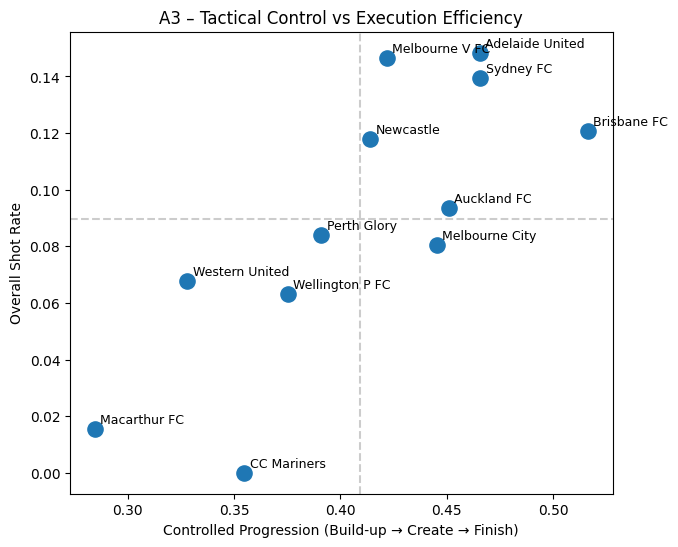

In [44]:
fig, ax = plt.subplots(figsize=(7, 6))

x = team_a3_df["controlled_progression"]
y = team_a3_df["overall_shot_rate_all_phases"]

ax.scatter(x, y, s=120)

for i in range(len(team_a3_df)):
    ax.annotate(
        team_a3_df["team_name"].iloc[i],
        (x.iloc[i], y.iloc[i]),
        fontsize=9,
        xytext=(4, 4),
        textcoords="offset points"
    )

ax.set_xlabel("Controlled Progression (Build-up → Create → Finish)")
ax.set_ylabel("Overall Shot Rate")
ax.set_title("A3 – Tactical Control vs Execution Efficiency")

ax.axhline(y.mean(), color="grey", linestyle="--", alpha=0.4)
ax.axvline(x.mean(), color="grey", linestyle="--", alpha=0.4)

plt.show()

Achsen

X: Controlled Progression
→ Wie gut ein Team kontrolliert von Build-up → Create → Finish kommt

Y: Overall Shot Rate
→ Wie effizient diese Kontrolle in Abschlüsse übersetzt wird

Gestrichelte Linien

Team-Durchschnitt (Liga-Baseline)

Oben rechts – „Control + Execution“ (Elite-Profil)

Beispiele:

Adelaide United

Sydney FC

Melbourne Victory

 Interpretation:

Hohe strukturelle Kontrolle

UND hohe Abschluss-Effizienz
➡️ reifes Ballbesitz-/Positionsspiel

 Unten rechts – „Control ohne Output“

Beispiele:

Auckland FC

Melbourne City

Interpretation:

Gute Phasenprogression

Aber Probleme im letzten Drittel
➡️ Coaching-Ansatzpunkt: Entscheidungsfindung / Box-Penetration

 Oben links – „Chaos mit Effektivität“

Beispiel:

Newcastle

 Interpretation:

Weniger strukturierte Progression

Aber trotzdem Abschlüsse
➡️ Direktspiel, Transition-Fokus, weniger Ballbesitz nötig

 Unten links – „Strukturelle Probleme“

Beispiele:

Macarthur FC

CC Mariners

 Interpretation:

Kaum Kontrolle

Kaum Abschlüsse
➡️ fundamentale Aufbau- und Strukturthemen

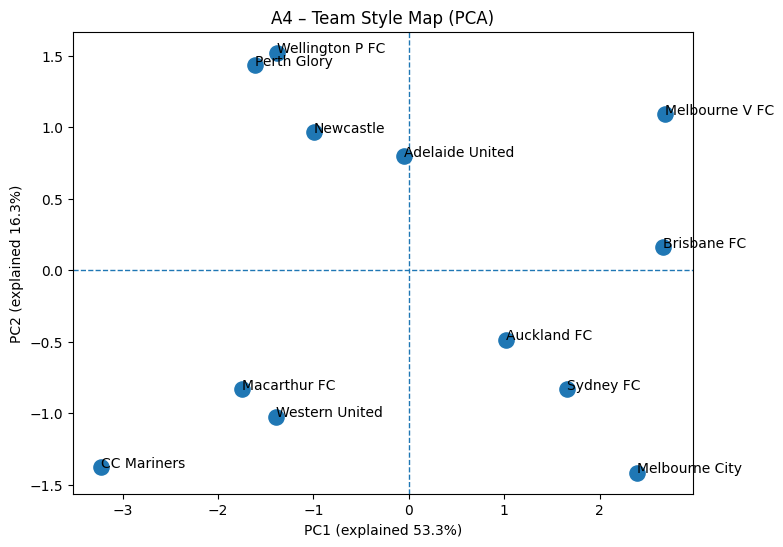

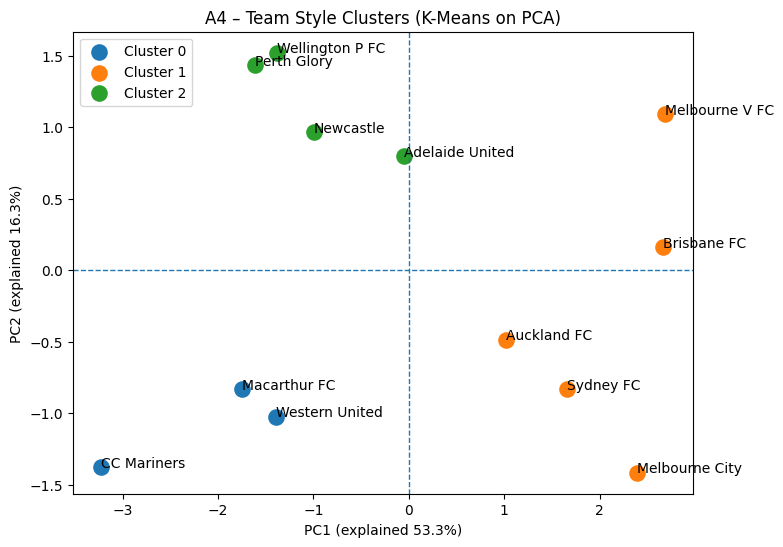

,team_name,PC1,PC2,cluster
0,Adelaide United,-0.050034,0.798447,2
1,Auckland FC,1.016802,-0.487201,1
2,Brisbane FC,2.668021,0.161259,1
3,CC Mariners,-3.227677,-1.375913,0
4,Macarthur FC,-1.752416,-0.833855,0
5,Melbourne City,2.394430,-1.415570,1
6,Melbourne V FC,2.683501,1.089505,1
7,Newcastle,-0.999412,0.966169,2
8,Perth Glory,-1.617236,1.432606,2
9,Sydney FC,1.655736,-0.831260,1


In [46]:
# A4.1 Features definieren (numerisch)

STYLE_FEATURES = [
    "total_time_build_up_pct",
    "total_time_create_pct",
    "total_time_finish_pct",
    "total_time_low_block_pct",
    "total_time_medium_block_pct",
    "total_time_high_block_pct",
    "stability_index",
    "overall_shot_rate_all_phases",
]


# A4.2 Team-Level Aggregation über alle Matches
# (mean = "typischer Style" eines Teams über den Zeitraum)

missing = [c for c in STYLE_FEATURES if c not in all_games_df.columns]
if missing:
    raise KeyError(f"Diese Spalten fehlen in all_games_df: {missing}")

style_df = (
    all_games_df
    .groupby("team_name")[STYLE_FEATURES]
    .mean()
    .reset_index()
)

# NaNs absichern (falls einzelne Teams in manchen Matches keine Phase hatten)
style_df[STYLE_FEATURES] = style_df[STYLE_FEATURES].fillna(0)

# A4.3 PCA rechnen

X = style_df[STYLE_FEATURES].values
team_names = style_df["team_name"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "team_name": team_names,
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
})

# Erklärte Varianz (nice für Interpretation)
explained = pca.explained_variance_ratio_

# A4.4 Plot: Style Map

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pca_df["PC1"], pca_df["PC2"], s=120)

for _, row in pca_df.iterrows():
    ax.annotate(row["team_name"], (row["PC1"], row["PC2"]))

ax.axhline(0, linestyle="--", linewidth=1)
ax.axvline(0, linestyle="--", linewidth=1)

ax.set_xlabel(f"PC1 (explained {explained[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 (explained {explained[1]*100:.1f}%)")
ax.set_title("A4 – Team Style Map (PCA)")

plt.show()


# A4.5 Clustering (K-Means)

K = 3  # kannst du auf 2–5 testen
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
pca_df["cluster"] = kmeans.fit_predict(X_pca)

fig, ax = plt.subplots(figsize=(8, 6))
for cl in sorted(pca_df["cluster"].unique()):
    subset = pca_df[pca_df["cluster"] == cl]
    ax.scatter(subset["PC1"], subset["PC2"], s=120, label=f"Cluster {cl}")

for _, row in pca_df.iterrows():
    ax.annotate(row["team_name"], (row["PC1"], row["PC2"]))

ax.axhline(0, linestyle="--", linewidth=1)
ax.axvline(0, linestyle="--", linewidth=1)

ax.set_xlabel(f"PC1 (explained {explained[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 (explained {explained[1]*100:.1f}%)")
ax.set_title("A4 – Team Style Clusters (K-Means on PCA)")
ax.legend()

plt.show()

pca_df


Achsenbedeutung (entscheidend!)

PC1 (53.3 %)
→ Ballbesitz- & Progressionsorientierung
(viel Create/Finish, wenig Low Block)

PC2 (16.3 %)
→ Tempo & Defensive Kontext
(Transition-lastig vs. strukturierter Aufbau)

Zusammen erklären die ersten 2 PCs ~70 % der Stilvarianz → sehr gut

 Rechte Seite (hoher PC1)

Progressive / dominante Teams

Melbourne City

Melbourne V FC

Brisbane FC

Sydney FC

➡️ Viel Create/Finish
➡️ Hohe Shot Rates
➡️ Weniger Low Block
➡️ „Wir diktieren das Spiel“

inke Seite (niedriger PC1)

Reaktive / defensive Teams

CC Mariners

Macarthur FC

Western United

➡️ Mehr Low / Medium Block
➡️ Weniger kontrollierte Progression
➡️ Geringere Shot-Rates

Oben (hoher PC2)

Struktur + Übergangskontrolle

Wellington P FC

Perth Glory

Newcastle

Adelaide United

➡️ Phasenstabil
➡️ Klare Build-up → Create Abläufe
➡️ Weniger Chaos

Unten (niedriger PC2)

Chaotischer / direkter Stil

Melbourne City

Sydney FC

Auckland FC

➡️ Schnellere Transitions
➡️ Weniger stabile Phase-Abfolgen
➡️ Dafür hohe Output-Effizienz